### Simple Calculation of attentation score

In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

In [1]:
import torch

inputs = torch.tensor(
    [
        [0.43, 0.15, 0.89],  # Your (x^1)
        [0.55, 0.87, 0.66],  # journey (x^2)
        [0.57, 0.85, 0.64],  # starts (x^3)
        [0.22, 0.58, 0.33],  # with (x^4)
        [0.77, 0.25, 0.10],  # one (x^5)
        [0.05, 0.80, 0.55],
    ]  # step (x^6)
)

### Just for `journey`

In [2]:
query = inputs[1]
attentation_score = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attentation_score[i] = query @ x_i  # Dot Product
## attentation_score sum
print(attentation_score.sum())
## normalize att score
attentation_score_norm = (
    attentation_score / attentation_score.sum()
)  # Done to increase training stability, generally done using softmax
print(attentation_score_norm)
## normalize att score sum
print(attentation_score_norm.sum())

tensor(6.5617)
tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
tensor(1.0000)


In [3]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)


# better norm to handle extreme values, and ensure weights are +ve
atte_score_norm = softmax_naive(attentation_score)
atte_score_norm

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

In [4]:
# context vector
context_vector = torch.empty(inputs.shape[1])
for i, x_i in enumerate(inputs):
    context_vector += (
        atte_score_norm[i] * x_i
    )  # Multiply the atten score for that input with input and sum them together
context_vector

tensor([0.4419, 0.6515, 0.5683])

### Atten and Context Calculation for everything naive

In [5]:
## norm att
att = torch.empty((inputs.shape[0], inputs.shape[0]))
for idx, query in enumerate(inputs):
    for i, x_i in enumerate(inputs):
        att[idx][i] = query @ x_i
att_norm = torch.softmax(att, dim=1)  # torch softmax bro
# context vector
context = torch.empty(inputs.shape)
for idx, a_n in enumerate(att_norm):
    for i, x_i in enumerate(inputs):
        context[idx] += a_n[i] * x_i
context[1]

tensor([0.4419, 0.6515, 0.5683])

### Atten and Context Calculation for everything matrix

In [6]:
att = inputs @ inputs.T
att_norm = torch.softmax(att, dim=1)  # torch softmax bro
context = att_norm @ inputs
context[1]

tensor([0.4419, 0.6515, 0.5683])

### Adding trainable parameters to the self-attentation

>from the book:
>
>**Weight parameters vs. attentation weights**
>
>In the weight matrices W, the term “weight” is short for “weight parameters,” the val-
ues of a neural network that are optimized during training. This is not to be confused
with the attentation weights. As we already saw, attentation weights determine the extent
to which a context vector depends on the different parts of the input (i.e., to what
extent the network focuses on different parts of the input).
In summary, weight parameters are the fundamental, learned coefficients that define
the network’s connections, while attentation weights are dynamic, context-specific values.

In [7]:
torch.manual_seed(123)
x_2 = inputs[1]
d_in = inputs.shape[1]  # 3
d_out = 2
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

query_2 = x_2 @ W_query
print(query_2)

tensor([0.4306, 1.4551])


In [8]:
key = inputs @ W_key
value = inputs @ W_value

# We need to compute the att_score for journey with just key[1]
att_score_22 = query_2 @ key[1]
att_score_22

tensor(1.8524)

In [9]:
# Getting actual att score for `journey`
att_score_2 = query_2 @ key.T
# Scaling the att
d_k = key.shape[-1]
attn_weights_2 = torch.softmax(att_score_2 / d_k**0.5, dim=-1)
context_vec2 = attn_weights_2 @ value
context_vec2

tensor([0.3061, 0.8210])

In [10]:
from attentation import SelfAttentationV0

In [11]:
torch.manual_seed(123)
SelfAttentationV0(d_in, d_out)(inputs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)

### Casual Attentation (Masked Attentation) v0

In [12]:
# Init Weight for K, Q, V
w_K = torch.nn.Parameter(torch.rand(3, 2))
w_Q = torch.nn.Parameter(torch.rand(3, 2))
w_V = torch.nn.Parameter(torch.rand(3, 2))
# Calculate K, Q, V
K = inputs @ w_K
Q = inputs @ w_Q
V = inputs @ w_V
# Compute omega
omega = K @ Q.T
# Att Weight
att_weight = torch.softmax(omega/K.shape[-1]**0.5, dim=-1)
# Masked Att
mask = torch.tril(torch.ones(att_weight.shape[0], att_weight.shape[0]))
masked_att_simple = mask*att_weight
# Renormalize
masked_att_simple = masked_att_simple/masked_att_simple.sum(dim=1, keepdim=True)
masked_att_simple

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3170, 0.6830, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1915, 0.4088, 0.3998, 0.0000, 0.0000, 0.0000],
        [0.2051, 0.3090, 0.3051, 0.1807, 0.0000, 0.0000],
        [0.1738, 0.2536, 0.2511, 0.1625, 0.1590, 0.0000],
        [0.1419, 0.2408, 0.2367, 0.1192, 0.1126, 0.1487]],
       grad_fn=<DivBackward0>)

### Casual Attentation (Masked Attentation) v1

In [28]:
# Init Weight for K, Q, V
w_K = torch.nn.Parameter(torch.rand(3, 2))
w_Q = torch.nn.Parameter(torch.rand(3, 2))
w_V = torch.nn.Parameter(torch.rand(3, 2))
# Calculate K, Q, V
K = inputs @ w_K
Q = inputs @ w_Q
V = inputs @ w_V
# Compute omega
omega = K @ Q.T
mask = torch.triu(torch.ones(omega.shape[0], omega.shape[0]), diagonal=1)
masked_omega = omega.masked_fill(mask.bool(), -torch.inf)
# Att Weight
masked_att_weight = torch.softmax(masked_omega/K.shape[-1]**0.5, dim=-1)
masked_att_weight

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4916, 0.5084, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3267, 0.3380, 0.3352, 0.0000, 0.0000, 0.0000],
        [0.2605, 0.2651, 0.2638, 0.2106, 0.0000, 0.0000],
        [0.2104, 0.2166, 0.2160, 0.1749, 0.1821, 0.0000],
        [0.1857, 0.1888, 0.1875, 0.1419, 0.1409, 0.1552]],
       grad_fn=<SoftmaxBackward0>)

### Casual Attentation (Masked Attentation) v3(Drop out)

In [29]:
# Init Weight for K, Q, V
w_K = torch.nn.Parameter(torch.rand(3, 2))
w_Q = torch.nn.Parameter(torch.rand(3, 2))
w_V = torch.nn.Parameter(torch.rand(3, 2))
# Calculate K, Q, V
K = inputs @ w_K
Q = inputs @ w_Q
V = inputs @ w_V
# Compute omega
omega = K @ Q.T
mask = torch.triu(torch.ones(omega.shape[0], omega.shape[0]), diagonal=1)
masked_omega = omega.masked_fill(mask.bool(), -torch.inf)
# Att Weight
masked_att_weight = torch.softmax(masked_omega/K.shape[-1]**0.5, dim=-1)
dropout = torch.nn.Dropout()
dropout(masked_att_weight)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1547, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7366, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4874, 0.5815, 0.5743, 0.3568, 0.0000, 0.0000],
        [0.4083, 0.0000, 0.0000, 0.3405, 0.3372, 0.0000],
        [0.3579, 0.4565, 0.0000, 0.2306, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

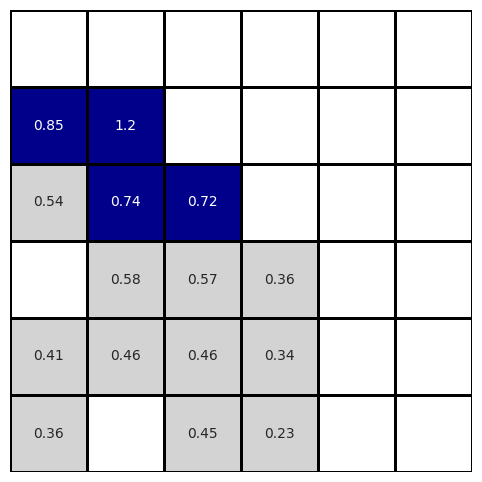

In [47]:
# Plot the attentation matrix
att = dropout(masked_att_weight).detach().numpy()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(att, annot=True, cmap=ListedColormap(['lightgray', 'darkblue']), cbar=False, linewidths=2, linecolor='black', square=True, mask = att == 0)
ax.set_xticks([])
ax.set_yticks([])
plt.show()